In [2]:
## Load packages
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
from ggplot import *

pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_columns', 500)

In [3]:
from sys import platform
if platform == 'linux' or platform == 'linux2':
    datapath = '/home/alin/MyLearning/Kaggle/Sberbank/data/'
else:
    datapath = 'C:/Users/alin/Documents/SelfStudy/MyLearning/Kaggle/Sberbank/data/'
print datapath

/home/alin/MyLearning/Kaggle/Sberbank/data/


In [4]:

train_df = pd.read_csv(datapath + 'train.csv', parse_dates=['timestamp'])

test_df = pd.read_csv(datapath + 'test.csv', parse_dates=['timestamp'])

macro_df = pd.read_csv(datapath + 'macro.csv', parse_dates=['timestamp'])



count    3.047100e+04
mean     7.123035e+06
std      4.780111e+06
min      1.000000e+05
25%      4.740002e+06
50%      6.274411e+06
75%      8.300000e+06
max      1.111111e+08
Name: price_doc, dtype: float64


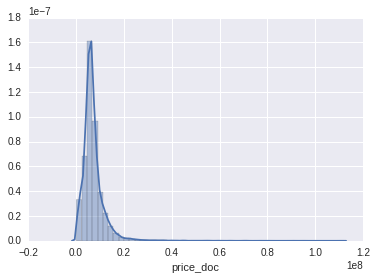

In [6]:
print(train_df['price_doc'].describe())
sns.distplot(train_df['price_doc'])

count    30471.000000
mean        15.609483
std          0.604574
min         11.512935
25%         15.371548
50%         15.651990
75%         15.931766
max         18.526041
Name: LogAmt, dtype: float64


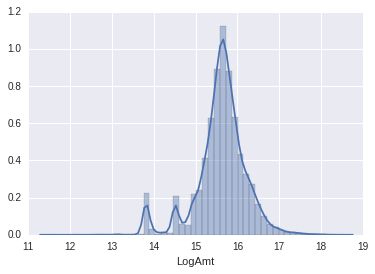

In [7]:
train_df['LogAmt']=np.log(train_df.price_doc+1.0)
print(train_df['LogAmt'].describe())
sns.distplot(train_df['LogAmt'])

In [ ]:
## Merge data into one dataset to prepare compare between train and test
train_1 = train_df.copy()
train_1['Source']='Train'
test_1 = test_df.copy()
test_1['Source']='Test'
alldata = pd.concat([train_1, test_1],ignore_index=True)

macro_df.columns = ['mac__'+c if c!='timestamp' else 'timestamp' for c in macro_df.columns ]

In [9]:
alldata=alldata.merge(macro_df,on='timestamp',how='left')
print(alldata.shape)

(38133, 393)


In [10]:
## Numerical and Categorical data types
alldata_dtype=alldata.dtypes
display_nvar = len(alldata.columns)
alldata_dtype_dict = alldata_dtype.to_dict()
alldata.dtypes.value_counts()

float64           216
int64             157
object             19
datetime64[ns]      1
dtype: int64


### Step 2: Transform Variables and Missing Data

#### Variable Description

I wrote this function with intension to compare train/test data and check if some variable is illy behaved. It is modified a little to fit this dataset to compared between normal/fraud subset.

It can be applied to both numeric and object data types:

    - When the data type is object, it will output the value count of each categories
    - When the data type is numeric, it will output the quantiles
    - It also seeks any missing values in the dataset



In [11]:
def var_desc(dt,alldata):
    print('--------------------------------------------')
    for c in alldata.columns:
        if alldata[c].dtype==dt:
            t1 = alldata[alldata.Source=='Train'][c]
            t2 = alldata[alldata.Source=='Test'][c]
            if dt=="object":
                f1 = t1[pd.isnull(t1)==False].value_counts()
                f2 = t2[pd.isnull(t2)==False].value_counts()
            else:
                f1 = t1[pd.isnull(t1)==False].describe()
                f2 = t2[pd.isnull(t2)==False].describe()
            m1 = t1.isnull().value_counts()
            m2 = t2.isnull().value_counts()
            f = pd.concat([f1, f2], axis=1)
            m = pd.concat([m1, m2], axis=1)
            f.columns=['Train','Test']
            m.columns=['Train','Test']
            print(dt+' - '+c)
            print('UniqValue - ',len(t1.value_counts()),len(t2.value_counts()))
            print(f.sort_values(by='Train',ascending=False))
            print()

            m_print=m[m.index==True]
            if len(m_print)>0:
                print('missing - '+c)
                print(m_print)
            else:
                print('NO Missing values - '+c)
            if dt!="object":
                if len(t1.value_counts())<=10:
                    c1 = t1.value_counts()
                    c2 = t2.value_counts()
                    c = pd.concat([c1, c2], axis=1)
                    f.columns=['Train','Test']
                    print(c)
            print('--------------------------------------------')

In [14]:
## Uncomment to run variable description
##var_desc('object',alldata)

In [15]:
%qtconsole

In [18]:
for c in alldata.columns:
    if alldata[c].dtype=='object' and c not in ['sub_area','timestamp','Source']:
        if len(alldata[c].value_counts())==2:
            alldata['num_'+c]=[0 if x in ['no','OwnerOccupier'] else 1 for x in alldata[c]]
        if len(alldata[c].value_counts())==5:
            alldata['num_'+c]=0
            alldata['num_'+c].loc[alldata[c]=='poor']=0
            alldata['num_'+c].loc[alldata[c]=='satisfactory']=1
            alldata['num_'+c].loc[alldata[c]=='good']=2
            alldata['num_'+c].loc[alldata[c]=='excellent']=3
            alldata['num_'+c].loc[alldata[c]=='no data']=1

In [19]:
## missing values
missing_col = [[c,sum(alldata[alldata.Source=='Train'][c].isnull()==True),sum(alldata[alldata.Source=='Test'][c].isnull()==True)] for c in alldata.columns]
missing_col = pd.DataFrame(missing_col,columns=['Var','missingTrain','missingTest'])



#### Missing Values

Below is an analysis of missing values. There are a couple variables with very rate of missing. So we want to keep them in the resv_col list so that we don't PCA them and make the entire set of the principal components as missing.


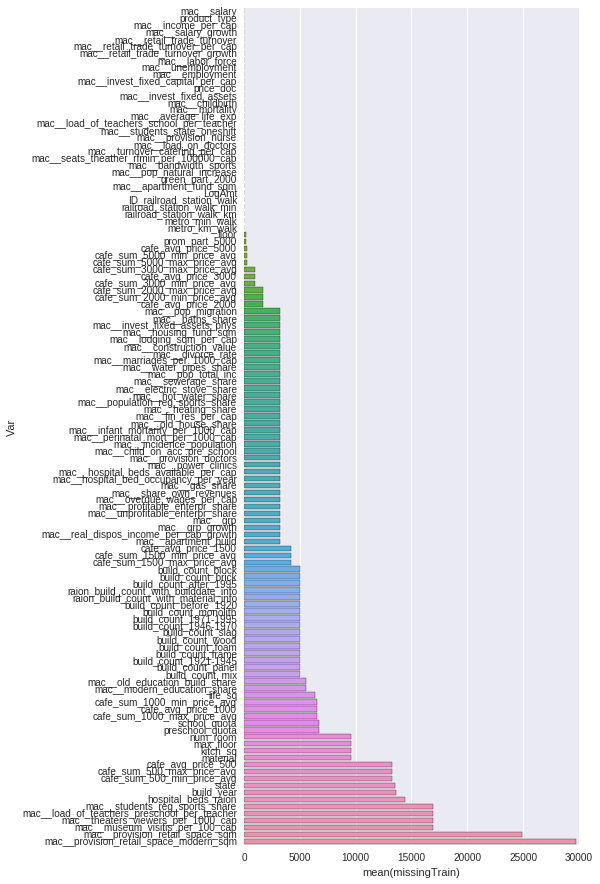

In [21]:
missingdf=missing_col[missing_col.missingTrain+missing_col.missingTest>0]
missingdf=missingdf.sort('missingTrain')
f, ax = plt.subplots(figsize=(6, 15))
sns.barplot(y=missingdf.Var,x=missingdf.missingTrain)


### Step 3: Principal Component Analysis

First, we group variables into small categories,

Then apply PCA on each of the categories and show correlation plots


In [22]:
excl_col=['id','timestamp','sub_area'] + [c for c in alldata.columns if alldata[c].dtype=='object']
resv_col=['price_doc','LogAmt','Source','cafe_sum_500_max_price_avg','cafe_sum_500_min_price_avg','cafe_avg_price_500','hospital_beds_raion']
def sel_grp(keys):
    lst_all = list()
    for k in keys:
        lst = [c for c in alldata.columns if c.find(k)!=-1 and c not in excl_col and c not in resv_col]
        lst = list(set(lst))
        lst_all += lst
    return(lst_all)

In [23]:
col_grp = dict({})
col_grp['people']=sel_grp(['_all','male'])
col_grp['id'] = sel_grp(['ID_'])
col_grp['church']=sel_grp(['church'])
col_grp['build']=sel_grp(['build_count_'])
col_grp['cafe']=sel_grp(['cafe_count'])
col_grp['cafeprice']=sel_grp(['cafe_sum','cafe_avg'])
col_grp['km']=sel_grp(['_km','metro_min','_avto_min','_walk_min','_min_walk'])
col_grp['mosque']=sel_grp(['mosque_count'])
col_grp['market']=sel_grp(['market_count'])
col_grp['office']=sel_grp(['office_count'])
col_grp['leisure']=sel_grp(['leisure_count'])
col_grp['sport']=sel_grp(['sport_count'])
col_grp['green']=sel_grp(['green_part'])
col_grp['prom']=sel_grp(['prom_part'])
col_grp['trc']=sel_grp(['trc_count'])
col_grp['sqm']=sel_grp(['_sqm_'])
col_grp['raion']=sel_grp(['_raion'])
col_grp['macro']=sel_grp(['mac__'])
col_grp.keys()

['sport',
 'raion',
 'office',
 'people',
 'macro',
 'trc',
 'mosque',
 'leisure',
 'km',
 'cafeprice',
 'prom',
 'green',
 'build',
 'sqm',
 'church',
 'cafe',
 'id',
 'market']

In [25]:
col_tmp = list()
for d in col_grp:
    col_tmp+=(col_grp[d])
col_grp['other']=[c for c in alldata.columns if c not in col_tmp and c not in excl_col and c not in resv_col]
col_grp['other']  ## these 'other' variables are not to be PCA

['area_m',
 'build_year',
 'children_preschool',
 'children_school',
 'floor',
 'full_sq',
 'green_zone_part',
 'indust_part',
 'kitch_sq',
 'life_sq',
 'material',
 'max_floor',
 'num_room',
 'preschool_quota',
 'raion_popul',
 'school_quota',
 'state',
 'num_big_road1_1line',
 'num_culture_objects_top_25',
 'num_ecology',
 'num_product_type',
 'num_railroad_1line',
 'num_water_1line']

In [26]:
## remove variables in macro data with too many missing data
macro_missing_2 = pd.DataFrame([[c,sum(alldata[c].isnull())] for c in col_grp['macro']],columns=['Var','Missing'])
macro_missing_3=macro_missing_2[macro_missing_2.Missing>5000]
print(macro_missing_3)
excl_col+=list(macro_missing_3.Var)
print(excl_col)

col_grp['macro']=sel_grp(['mac__'])

                                            Var  Missing
1                              mac__baths_share    10901
10                                     mac__grp    10901
12       mac__provision_retail_space_modern_sqm    37380
13              mac__museum_visitis_per_100_cap    24563
14                           mac__pop_total_inc    10901
15  mac__load_of_teachers_preschool_per_teacher    24563
21                  mac__marriages_per_1000_cap    10901
22             mac__population_reg_sports_share    10901
28                mac__invest_fixed_assets_phys    10901
30                mac__profitable_enterpr_share    10901
34                               mac__gas_share    10901
37           mac__theaters_viewers_per_1000_cap    24563
38              mac__unprofitable_enterpr_share    10901
45                    mac__incidence_population    10901
46                       mac__provision_doctors    10901
47                    mac__electric_stove_share    10901
50              mac__provision_

In [27]:
loopkeys=list(col_grp.keys())
print(loopkeys)

['sport', 'raion', 'office', 'people', 'macro', 'trc', 'mosque', 'leisure', 'km', 'cafeprice', 'prom', 'other', 'green', 'build', 'sqm', 'church', 'cafe', 'id', 'market']


In [28]:
def partial_pca(var,data,col_grp):
    from sklearn.decomposition import PCA
    import bisect
    pca = PCA()
    df = data[col_grp[var]].dropna()
    print([len(data[col_grp[var]]), len(df)])
    df = (df-df.mean())/df.std(ddof=0)
    pca.fit(df)
    varexp = pca.explained_variance_ratio_.cumsum()
    cutoff = bisect.bisect(varexp, 0.95)
    #print(cutoff)
    #print(pca.explained_variance_ratio_.cumsum())
    newcol=pd.DataFrame(pca.fit_transform(X=df)[:,0:(cutoff+1)],columns=['PCA_'+var+'_'+str(i) for i in range(cutoff+1)],index=df.index)
    #print(newcol)
    col_grp['PCA_'+var]=list(newcol.columns)
    return(newcol,col_grp,pca)

In [29]:
for c in loopkeys:
    if c!='other':
        print(c)
        newcol,col_grp,pca = partial_pca(c,alldata,col_grp)
        alldata=alldata.join(newcol)
        print(alldata.shape)

sport
[38133, 38133]
(38133, 410)
raion
[38133, 38133]
(38133, 423)
office
[38133, 38133]
(38133, 425)
people
[38133, 38133]
(38133, 427)
macro
[38133, 34150]
(38133, 439)
trc
[38133, 38133]
(38133, 442)
mosque
[38133, 38133]
(38133, 447)
leisure
[38133, 38133]
(38133, 450)
km
[38133, 38074]
(38133, 468)
cafeprice
[38133, 30387]
(38133, 472)
prom
[38133, 37863]
(38133, 475)
green
[38133, 38114]
(38133, 478)
build
[38133, 31924]
(38133, 485)
sqm
[38133, 27232]
(38133, 492)
church
[38133, 38133]
(38133, 496)
cafe
[38133, 38133]
(38133, 499)
id
[38133, 38074]
(38133, 505)
market
[38133, 38133]
(38133, 509)



### Correlation

Correlation is useful to find peers of input field so we are aware when building models, either to transform them (principal component) or remove one of the two. The first plot below the overall correlation matrix and there are blocks of variables that are highly correlated The second plot shows the highly correlated variables with response.


In [30]:
wpca=list()
wopca=list()
for c in col_grp.keys():
    if c.find('PCA_')!=-1:
        wpca+=col_grp[c]
    else:
        wopca+=col_grp[c]
        
wpca+=col_grp['other']
wpca+=resv_col
wopca+=col_grp['other']
wopca+=resv_col

wpca=list(set(wpca))
wopca=list(set(wopca))

wpca.sort()
wopca.sort()


Below is a comparison of w/o PCA and w/ PCA correlation, after PCA transformation, it looks much better in terms of high correlated variables. It is also interesting to notice that some of the intra-group principal components have high correlations.

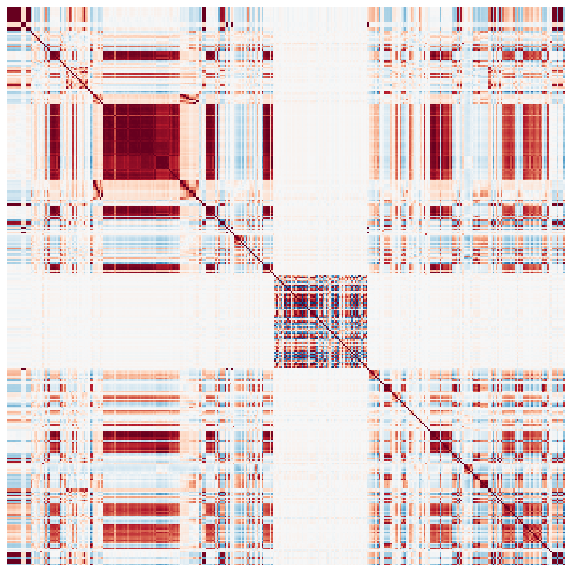

In [31]:
## Correlation without PCA
corrmat = alldata[wopca].corr()
f, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(corrmat, vmax=.8, square=True,xticklabels=False,yticklabels=False,cbar=False,annot=False);

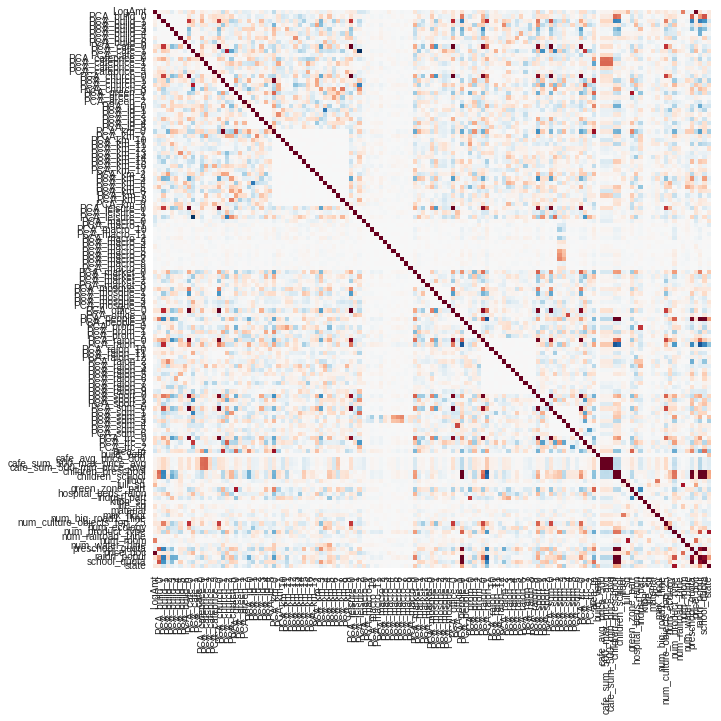

In [32]:
## Correlation with PCA
corrmat = alldata[wpca].corr()
f, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(corrmat, vmax=.8, square=True,xticklabels=True,yticklabels=True,cbar=False,annot=False);

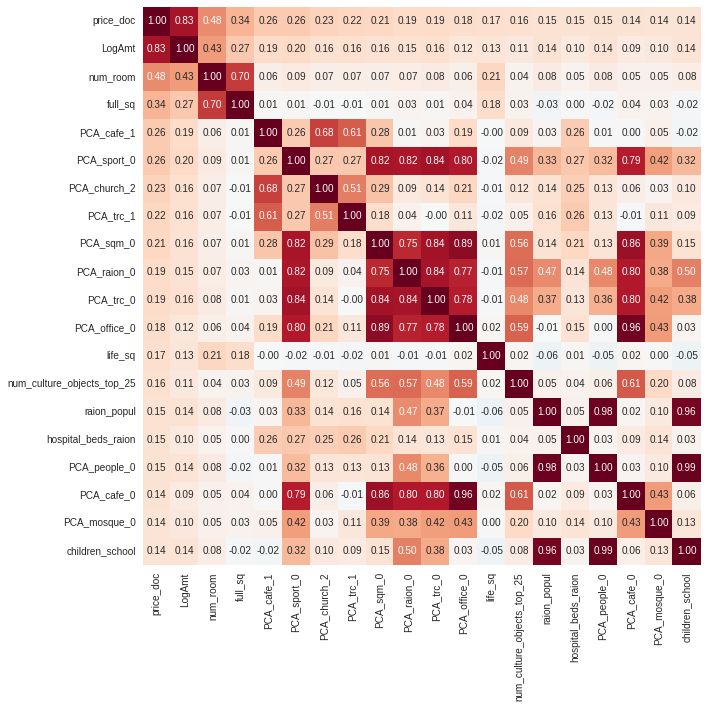

In [33]:
## Top 20 correlated variables
corrmat = alldata[wpca].corr()
k = 20 #number of variables for heatmap
cols = corrmat.nlargest(k, 'price_doc')['price_doc'].index
cm = alldata[cols].corr()
f, ax = plt.subplots(figsize=(10, 10))
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=False, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()


### XGB and Light gbm on the PCA transformed Data

Now PCA transformed data shows much better correlation. Next we will test a simple XGB model and see its performance.


In [35]:
## these are the variables going into the model.
alldata[wpca].columns


Index([u'LogAmt', u'PCA_build_0', u'PCA_build_1', u'PCA_build_2',
       u'PCA_build_3', u'PCA_build_4', u'PCA_build_5', u'PCA_build_6',
       u'PCA_cafe_0', u'PCA_cafe_1',
       ...
       u'num_ecology', u'num_product_type', u'num_railroad_1line', u'num_room',
       u'num_water_1line', u'preschool_quota', u'price_doc', u'raion_popul',
       u'school_quota', u'state'],
      dtype='object', length=132)

In [36]:
## Add a few more features suggested by other discussions
##
# Add month-year
month_year = (alldata.timestamp.dt.month + alldata.timestamp.dt.year * 100)
month_year_cnt_map = month_year.value_counts().to_dict()
alldata['month_year_cnt'] = month_year.map(month_year_cnt_map)

# Add week-year count
week_year = (alldata.timestamp.dt.weekofyear + alldata.timestamp.dt.year * 100)
week_year_cnt_map = week_year.value_counts().to_dict()
alldata['week_year_cnt'] = week_year.map(week_year_cnt_map)

# Add month and day-of-week
alldata['month'] = alldata.timestamp.dt.month
alldata['dow'] = alldata.timestamp.dt.dayofweek

# Other feature engineering
alldata['rel_floor'] = alldata['floor'] / alldata['max_floor'].astype(float)
alldata['rel_kitch_sq'] = alldata['kitch_sq'] / alldata['full_sq'].astype(float)

In [37]:
wpca +=['month_year_cnt','week_year_cnt','dow','month','rel_floor','rel_kitch_sq']
wopca+=['month_year_cnt','week_year_cnt','dow','month','rel_floor','rel_kitch_sq']
allfeature=list(set(wpca+wopca))

In [40]:
import xgboost as xgb

In [56]:
train_col = [c for c in alldata[wpca].columns if c not in ['price_doc','Source', 'LogAmt']]
X_train = alldata[alldata.Source=='Train'][train_col]
y_train = alldata[alldata.Source == 'Train']['LogAmt']

In [59]:
test_col = [c for c in alldata[wpca].columns if c not in ['price_doc','Source', 'LogAmt']]
X_test = alldata[alldata.Source=='Test'][test_col]

In [60]:
xgtrain = xgb.DMatrix(X_train, y_train)
xgtest = xgb.DMatrix(X_test)

In [61]:
xgb_params = {
    'eta': 0.1,
    'max_depth': 5,
     'min_child_weight': 1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}

In [63]:
#cvresult = xgb.cv(xgb_params, xgtrain, num_boost_round=1000, nfold=5, metrics='rmse', early_stopping_rounds=50, verbose_eval=True)

In [64]:
num_rounds = 171

In [66]:
model = xgb.train(xgb_params, xgtrain, num_boost_round=num_rounds, evals = [(xgtrain, 'train')], verbose_eval=20)
# make prediction
y_pred1 = model.predict(xgtest)

[0]	train-rmse:13.6117
[20]	train-rmse:1.72178
[40]	train-rmse:0.492346
[60]	train-rmse:0.434128
[80]	train-rmse:0.422503
[100]	train-rmse:0.41381
[120]	train-rmse:0.406557
[140]	train-rmse:0.401019
[160]	train-rmse:0.395111
[170]	train-rmse:0.392011


In [68]:
tid = test_df.id

In [69]:
price1 = np.exp(y_pred1) - 1
output1 = pd.DataFrame({'id':tid, 'price_doc': price1})
output1.to_csv('/home/alin/MyLearning/Kaggle/Sberbank/data/submission5.csv', index = False)

In [70]:
import lightgbm as lgb

In [71]:
lgb_train = lgb.Dataset(X_train, y_train)
lgb_test = lgb.Dataset(X_test)

In [72]:
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression_l2',
    'metric': {'rmse'},
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
    }

In [74]:
#cv_lgb = lgb.cv(params, lgb_train, num_boost_round = 1000, nfold=5, early_stopping_rounds = 50, 
#                verbose_eval = True)

In [75]:
gbm = lgb.train(params,lgb_train,num_boost_round=247)

In [76]:
y_pred2 = gbm.predict(X_test)
price2 = np.exp(y_pred2) - 1
output2 = pd.DataFrame({'id':tid, 'price_doc': price2})
output2.to_csv('/home/alin/MyLearning/Kaggle/Sberbank/data/submission6.csv', index = False)